In [2]:
pass_list = [0,0,0,0,0]
subject_note_lower = 27
subject_note_upper = 100

# pass_list = [0]

### 常見錯誤:
### too much error segment: please face the microphone


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
a 分析結果:
最低音限制(< 27 ): 23.969 pass
最高音限制(> 37 ): 38.239 pass


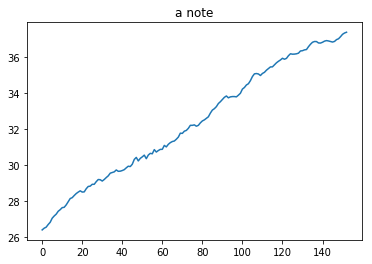

del_note(<= 0.35 ): 0.23114255777853998 pass


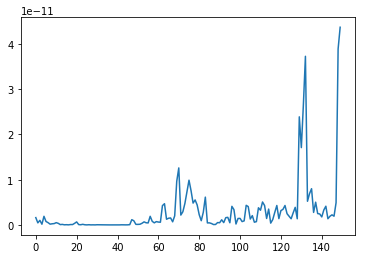

del_sp(< 1e-06 ): 4.368328717492961e-11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
i 分析結果:
最低音限制(< 27 ): 26.391 pass
最高音限制(> 37 ): 37.388 pass
include 2.wav


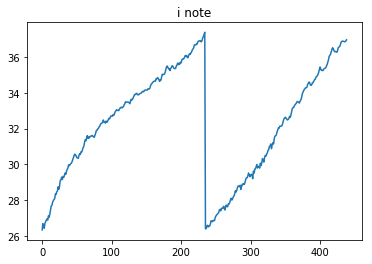

del_note(<= 0.35 ): 0.13188313733907364 pass


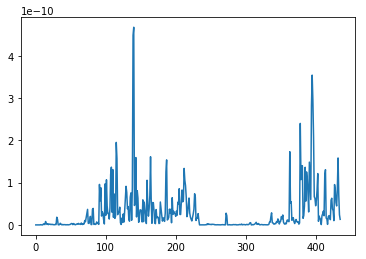

del_sp(< 1e-06 ): 4.676545322121636e-10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
u 分析結果:
最低音限制(< 27 ): 26.352 pass
最高音限制(> 37 ): 37.368 pass


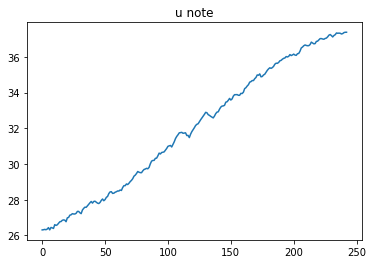

del_note(<= 0.35 ): 0.20090967771076862 pass


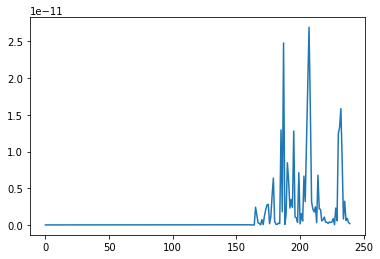

del_sp(< 1e-06 ): 2.6936693076973812e-11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
e 分析結果:
最低音限制(< 27 ): 26.304 pass
最高音限制(> 37 ): 37.386 pass


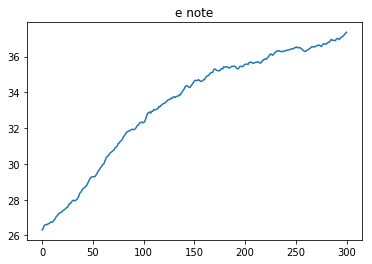

del_note(<= 0.35 ): 0.18533014384739843 pass


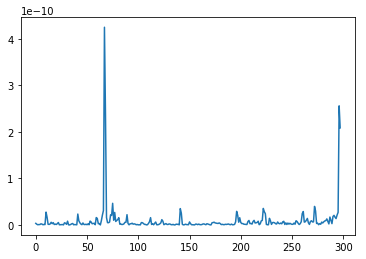

del_sp(< 1e-06 ): 4.2507570372724117e-10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
o 分析結果:
最低音限制(< 27 ): 26.312 pass
最高音限制(> 37 ): 37.364 pass
include 2.wav


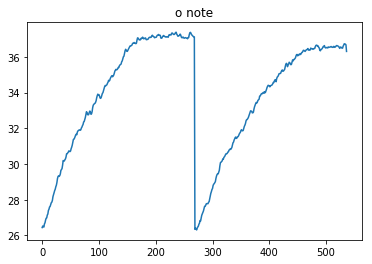

del_note(<= 0.35 ): 0.17894253067034782 pass


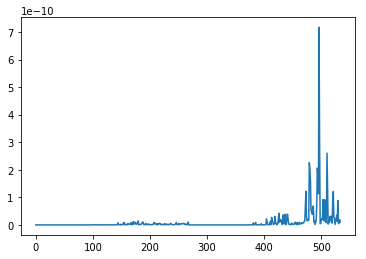

del_sp(< 1e-06 ): 7.170393482557978e-10
your pitch range: [27.0, 37.0]
saved pitch range: [27, 37]
==================結果===================
恭喜! 您的音檔可以使用，感謝您的配合!


In [5]:
pass_list = [0,0,0,0,0]
from termcolor import colored
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os.path

import soundfile as sf
# import librosa
import pyworld as pw

subject_note_lower = 0
subject_note_upper = 100

frame_period = 10.0 # millisecond
samples_per_frame = int(np.floor(44100.0 * frame_period/1000.0))

aiueo = ['a','i','u','e','o']

#28 38 9 男
#32 42 9 女

note_lower,note_upper = 27,37


pitch_range_file = open(r'./data/pRange.pkl', 'wb')

max_del_note = 0.35
del_sp_upper = 0.000001  #1.7
def get_valid_f0_idx(f0,max_note,min_note,tol = 5):
    f0_max = 440*np.power(2,(max_note-49.0)/12.0)
    f0_min = 440*np.power(2,(min_note-49.0)/12.0)
    idx = np.where(np.logical_and(f0>=f0_min-tol, f0<=f0_max+tol))
    return idx

for i in range(len(aiueo)):
    if pass_list[i]:
        print(aiueo[i] , "pass")
        continue
    isPass = True
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    file_cnt = 2
    wavname = 'data/'+aiueo[i]
    if not os.path.isfile(wavname+'.wav'):
        print(colored('錯誤:找不到音檔','red'),wavname+'.wav')
        continue

    x, fs = sf.read(wavname+'.wav')

    if fs != 44100:
        print("錯誤:請使用44100採樣率(sample rate:44100)")
        continue
    try:
        x = (x[:,0] + x[:,1])/2 # stereo to mono
        x = x/max(x)*0.5
    except:
        print("錯誤:請使用雙聲道(stereo 2 channel)錄音")
        continue
    num_of_frames = int(np.floor(len(x)/samples_per_frame))    
    f0, sp, _ = pw.wav2world(x, fs, frame_period =  frame_period)    # use default options
#     inf_cnt = 0
#     if inf_cnt != 0:
#         print(wavname,'音檔中有無法分析的片段，',len(f0_note),'片段中有',inf_cnt,'個片段無法分析，請再次嘗試:fail')
    
    print(aiueo[i],'分析結果:')   
    

    #criteria 1: max pitch ,min pitch
    f0 = f0[1:]    
    sp = sp[1:]
    
#     f0_note = 12*np.log2(f0/440)+49
    

    print("最低音限制(<",note_lower,"):",round(min(f0_note),3),"pass" if min(f0_note)<note_lower else "fail")
    print("最高音限制(>",note_upper,"):",round(max(f0_note),3),"pass" if max(f0_note)>note_upper else "fail")
    if (not max(f0_note)>note_upper) or ((not min(f0_note)<note_lower)):
        isPass = False 
    

    #criteria 2:minimun delta note (sorted) 
    
    #if there exist 2 file with same vowel, detect its f0 as well
    while os.path.isfile(wavname+str(file_cnt)+'.wav'):
        print('include',str(file_cnt)+'.wav' )
        x2,_ = sf.read(wavname+str(file_cnt)+'.wav')
        x2 = (x2[:,0] + x2[:,1])/2 # stereo to mono
        x2 = x2/max(x2)*0.5
        wavname = 'data/'+aiueo[i]+str(file_cnt)
        f02, sp2,_ = pw.wav2world(x2, fs, frame_period =  frame_period)    # use default options
        f02 = f02[1:]
        sp2 = sp2[1:]
        f0 =np.concatenate((f0,f02), axis=0)
        sp =np.concatenate((sp,sp2), axis=0)
        file_cnt +=1
    
    idx = get_valid_f0_idx(f0,note_upper,note_lower)
    f0_note = 12*np.log2(f0[idx]/440)+49
    #min_his = min(np.histogram(f0_note, bins=13)[0])
    sp = sp[idx]
    subject_note_lower = max(np.ceil(min(f0_note)),subject_note_lower)
    subject_note_upper = min(np.floor(max(f0_note)),subject_note_upper)
    
    plt.title(aiueo[i]+' note')
    plt.plot(f0_note)
    plt.show()

    sorted_note = np.array(sorted(i for i in f0_note if i < note_upper+1))
    del_note = abs(sorted_note[1:] - sorted_note[:-1])
    
    print("del_note(<=",max_del_note,"):",max(del_note),"pass" if max_del_note>=max(del_note) else "fail")
    if (not max(del_note)<=max_del_note):
        isPass = False
        
        plt.plot(sorted_note)
        plt.title(aiueo[i]+' sorted note')
        plt.show()
        plt.title(aiueo[i]+' del note')
        plt.plot(del_note)
        plt.show()

    #criteria 3:prevent noise 
    del_sp = np.mean(np.power(abs(sp[2:-1,400:]-sp[1:-2,400:]),2),axis= 1)
    max_del_sp = max(del_sp)
    plt.plot(del_sp)
    plt.show()
    print("del_sp(<",del_sp_upper,"):",max_del_sp)
    if (not max_del_sp<del_sp_upper):
        print("Warning: the audio file might contain noise, please check")
        plt.plot(del_sp)
        plt.show()

    if isPass:
        pass_list[i] = 1
        

pickle.dump([note_lower,note_upper], pitch_range_file)
pitch_range_file.close()
print("your pitch range:" ,[subject_note_lower,subject_note_upper])
print("saved pitch range:" ,[note_lower,note_upper])
print("==================結果===================")
if sum(pass_list) == len(aiueo):
    print("恭喜! 您的音檔可以使用，感謝您的配合!")
else:
    print("您提供的音檔尚有地方須修正，煩請改進fail與錯誤的部分")

In [16]:
print(sp.shape)

(1, 276, 1025)


In [27]:
foo = pickle.load(open("data/pRange.pkl", "rb"))
print(foo)

[26.0, 38.0]


In [41]:
g = np.array([0,1,2,3,4,5,6,7])
b = np.array([0,1,2,3,4,10,7])


print(set(g) & set(b))

{0, 1, 2, 3, 4, 7}


In [4]:
%history

# pass_list = [0,0,0,0,0]
from termcolor import colored
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os.path

import soundfile as sf
# import librosa
import pyworld as pw

#28 38 9 男
#32 42 9 女

frame_period = 10.0 # millisecond
samples_per_frame = int(np.floor(44100.0 * frame_period/1000.0))

aiueo = ['a','i','u','e','o']
isMale = 1
if isMale:
    note_lower,note_upper = 27,38
else:
    note_lower,note_upper = 32,42

pitch_range_file = open(r'./data/pRange.pkl', 'wb')

max_del_note = 0.35
del_sp_upper = 0.000001  #1.7


for i in range(len(aiueo)):
    if pass_list[i]:
        print(aiueo[i] , "pass")
        continue
    isPass = True
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    file_cnt = 2
    wavname = 'data/'+aiueo[i]
    if not os.path.isfile(wavname+'.wav'):
        print(colored('錯誤:找不到音檔','red'),wavname+'.wav')
        continue

    x, fs = sf.read(wavname+'.wav')

    if fs != 44100:
        print("錯誤:請使用44100採樣率(sample rate:44100)"